In [2]:
%reload_ext autoreload
%autoreload 2

import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../../")

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

from MAPIE.mapie.classification import MapieClassifier
from MAPIE.mapie.metrics import classification_coverage_score, classification_ssc, classification_ssc_score

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import mean_squared_error


def evaluate_regressor(model, regressor, X_calibration, y_calibration, method):
    y_true_residuals = get_residual(
        model=model, X=X_calibration, y=y_calibration, method=method
    )
    y_pred_residuals = regressor.predict(X_calibration)
    mse = mean_squared_error(y_true=y_true_residuals, y_pred=y_pred_residuals)
    rmse = np.sqrt(mse)
    print(f"Fitted regressor MSE = {mse}")
    print(f"Fitted regressor RMSE = {rmse}")


def count_null_set(y: np.ndarray) -> int:
    """
    Count the number of empty prediction sets.

    Parameters
    ----------
    y: np.ndarray of shape (n_sample, )

    Returns
    -------
    int
    """
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count


def get_residual(model, X, y, method):
    if method == "crf_score":
        y_pred_proba = model.predict_proba(X)
        y = y.to_numpy()
        y_res_predict_new = np.take_along_axis(
            1 - y_pred_proba, np.expand_dims(y, axis=1), axis=1
        )[:, 0]
    elif method == "crf_aps":
        y_pred_proba = model.predict_proba(X)
        cum_sum_proba = _get_true_label_cumsum_proba(y, y_pred_proba=y_pred_proba)
        y_res_predict_new = cum_sum_proba[0].ravel()
    return y_res_predict_new


def _get_true_label_cumsum_proba(
    y,
    y_pred_proba,
):
    y_true = label_binarize(y=y, classes=np.unique(y))
    index_sorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
    y_pred_proba_sorted = np.take_along_axis(y_pred_proba, index_sorted, axis=1)
    y_true_sorted = np.take_along_axis(y_true, index_sorted, axis=1)
    y_pred_proba_sorted_cumsum = np.cumsum(y_pred_proba_sorted, axis=1)
    cutoff = np.argmax(y_true_sorted, axis=1)
    true_label_cumsum_proba = np.take_along_axis(
        y_pred_proba_sorted_cumsum, cutoff.reshape(-1, 1), axis=1
    )

    return true_label_cumsum_proba, cutoff + 1


def visualize_dataset(X, y, title="Plot"):
    unique_classes = np.unique(y)
    colors = plt.cm.turbo(np.linspace(0, 1, len(unique_classes)))
    for i, cls in enumerate(unique_classes):
        class_indices = y == cls
        plt.scatter(
            X.loc[class_indices, "x"],
            X.loc[class_indices, "y"],
            color=colors[i],
            label="Class {}".format(cls),
        )
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend(title="Classes")
    plt.show()


def visualize_test_dataset(X, title="Plot"):
    plt.scatter(X["x"], X["y"])
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.show()


def mask_dataset(X, y, random_state, random_curve = True):
    X_copy = X.copy()
    y_copy = y.copy()
    # Générer les pentes et intercepts aléatoires pour chaque classe
    np.random.seed(random_state)  # Pour reproduire les mêmes valeurs aléatoires
    if random_curve:
        slopes = np.random.uniform(
            low=-2.0, high=2.0, size=4
        )  # Pentes aléatoires entre -2.0 et 2.0
        intercepts = np.random.uniform(
            low=-1.0, high=1.0, size=4
        )  # Intercepts aléatoires entre -1.0 et 1.0
    else:
        slopes = [1, 1, 1, 1]
        intercepts = [0, 0, 0, 0]
    for cls, slope, intercept in zip(range(4), slopes, intercepts):
        class_indices = y_copy == cls
        X_class = X_copy[class_indices]

        # Calculer les valeurs de y prédites pour chaque point
        y_predicted = slope * X_class["x"] + intercept
        nb_mask_left = len(X_class[np.sign(X_class["y"] - y_predicted) < 0].index)
        nb_mask_right = len(X_class[np.sign(X_class["y"] - y_predicted) > 0].index)

        if (nb_mask_left > nb_mask_right) or (not random_curve):
            # Supprimer les points situés d'un côté de la droite
            mask = np.sign(X_class["y"] - y_predicted) > 0
        else:
            # Supprimer les points situés de l'autre côté de la droite
            mask = np.sign(X_class["y"] - y_predicted) < 0
        X_copy = X_copy.drop(X_class[mask].sample(frac=0.9, random_state=42).index)
        y_copy = y_copy.drop(X_class[mask].sample(frac=0.9, random_state=42).index)

    return X_copy, y_copy


def visualize_all_datasets(X1, y1, X_train_masked, y_train_masked, X_test):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    unique_classes = np.unique(y1)
    colors = plt.cm.turbo(np.linspace(0, 1, len(unique_classes)))
    for i, cls in enumerate(unique_classes):
        class_indices = y1 == cls
        axes[0].scatter(
            X1.loc[class_indices, "x"],
            X1.loc[class_indices, "y"],
            color=colors[i],
            label="Class {}".format(cls),
        )
    axes[0].set_xlabel("x1")
    axes[0].set_ylabel("x2")
    axes[0].set_title("Classification dataset")

    for i, cls in enumerate(unique_classes):
        class_indices = y_train_masked == cls
        axes[1].scatter(
            X_train_masked.loc[class_indices, "x"],
            X_train_masked.loc[class_indices, "y"],
            color=colors[i],
            label="Class {}".format(cls),
        )
    axes[1].set_xlabel("x1")
    axes[1].set_ylabel("x2")
    axes[1].set_title("Masked Classification dataset")

    axes[2].scatter(X_test["x"], X_test["y"])
    axes[2].set_xlabel("x1")
    axes[2].set_ylabel("x2")
    axes[2].set_title("Test dataset")

    plt.tight_layout()
    plt.show()


def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(4, 3))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}",
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()


def plot_results(alphas, X, y_pred, y_ps):
    tab10 = plt.cm.get_cmap("Purples", 4)
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3: "#d62728"}
    y_pred_col = list(map(colors.get, y_pred))
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(16, 4))
    axs = {0: ax1, 1: ax2, 2: ax3, 3: ax4}
    axs[0].scatter(X[:, 0], X[:, 1], color=y_pred_col, marker=".", s=10, alpha=0.4)
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i + 1].scatter(
            X[:, 0],
            X[:, 1],
            c=y_pi_sums,
            marker=".",
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3,
        )
        plt.colorbar(num_labels, ax=axs[i + 1])
        axs[i + 1].set_title(f"Number of labels for alpha={alpha}")
    plt.show()


# Data generation

In [103]:
N_SAMPLES = 5000

X1, y1 = make_gaussian_quantiles(n_samples=N_SAMPLES, n_features=2, n_classes=5, random_state=42)
X2, y2 = make_gaussian_quantiles(n_samples=N_SAMPLES * 10, n_features=2, n_classes=5, random_state=42)
X2 = pd.DataFrame(X2, columns=['x', 'y']) #+ (noise)
y2 = pd.Series(y2)
mask = y2 != 4
X2_filtered = X2[mask]
y2_filtered = y2[mask]
# noise = np.random.rand(N_SAMPLES, 2)

X1 = pd.DataFrame(X1, columns=['x', 'y']) #+ (noise)
y1 = pd.Series(y1)

# Supprimer les observations de la classe numéro 5
mask = y1 != 4
X1_filtered = X1[mask]
y1_filtered = y1[mask]

np.random.seed(42)
X1_filtered["x"] += np.random.normal(scale=.1, size=len(X1_filtered))
X1_filtered["y"] += np.random.normal(scale=.1, size=len(X1_filtered))

## Création du mesh de test
x_min, x_max, y_min, y_max, step = -1.5, 1.5, -1.5, 1.5, 0.01

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)

In [104]:
X_train_masked, y_train_masked = mask_dataset(X1_filtered, y1_filtered, random_state=10, random_curve=False)
X_train_masked, X_test, y_train_masked, y_test = train_test_split(
    X_train_masked,
    y_train_masked,
    test_size=0.25,
    random_state=42
)
X_train_masked, X_cal_masked, y_train_masked, y_cal_masked = train_test_split(
    X_train_masked,
    y_train_masked,
    test_size=1/3,
    random_state=42
)
X_train_masked, X_res_masked, y_train_masked, y_res_masked = train_test_split(
    X_train_masked,
    y_train_masked,
    test_size=1/2,
    random_state=42
)

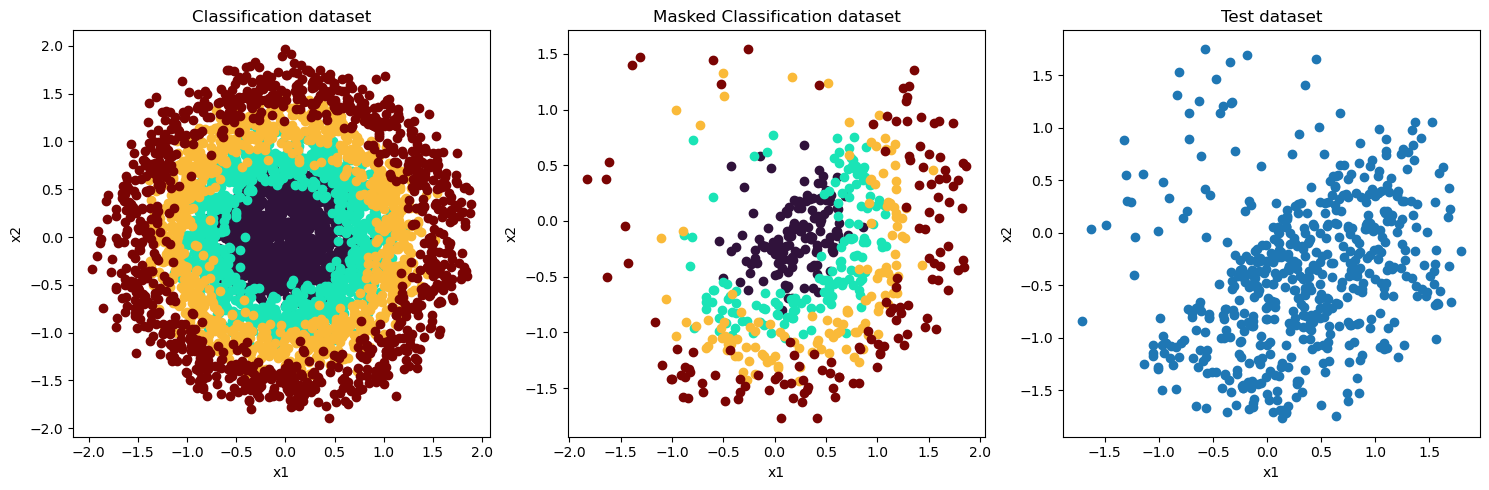

In [105]:
visualize_all_datasets(X1_filtered, y1_filtered, X_train_masked, y_train_masked, X_test)

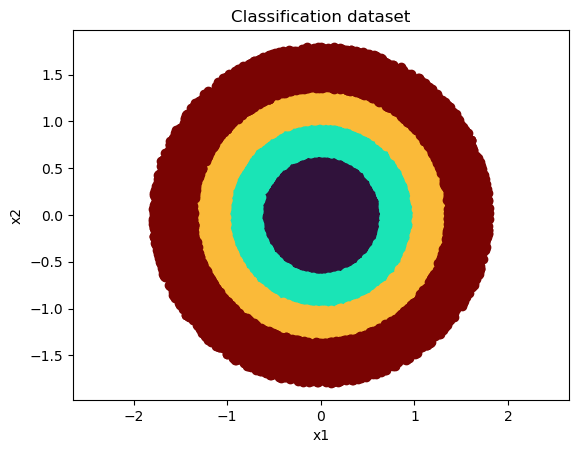

In [106]:
unique_classes = np.unique(y2_filtered)
colors = plt.cm.turbo(np.linspace(0, 1, len(unique_classes)))
for i, cls in enumerate(unique_classes):
    class_indices = y2_filtered == cls
    plt.scatter(
        X2_filtered.loc[class_indices, "x"],
        X2_filtered.loc[class_indices, "y"],
        color=colors[i],
        label="Class {}".format(cls),
    )
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Classification dataset")
plt.axis("equal")
plt.show()

# Prediction Model

In [14]:
model = SVC(probability=True).fit(X_train_masked, y_train_masked)
model_preds = model.predict(X_test)

print(f'Accuracy score is : {accuracy_score(y_test, model_preds):.3f}')

Accuracy score is : 0.839


# SCORE Method

In [15]:
mapie_score = MapieClassifier(estimator=model, cv="prefit", method="score")
mapie_score.fit(X_cal_masked, y_cal_masked)
alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test_mesh, alpha=alpha)

In [16]:
classification_ssc(y_test, mapie_score.predict(X_test, alpha=alpha)[1])

array([[0.        , 0.84473198, 1.        ,        nan,        nan],
       [       nan, 0.92420538, 1.        ,        nan,        nan],
       [       nan, 0.95283019, 1.        ,        nan,        nan]])

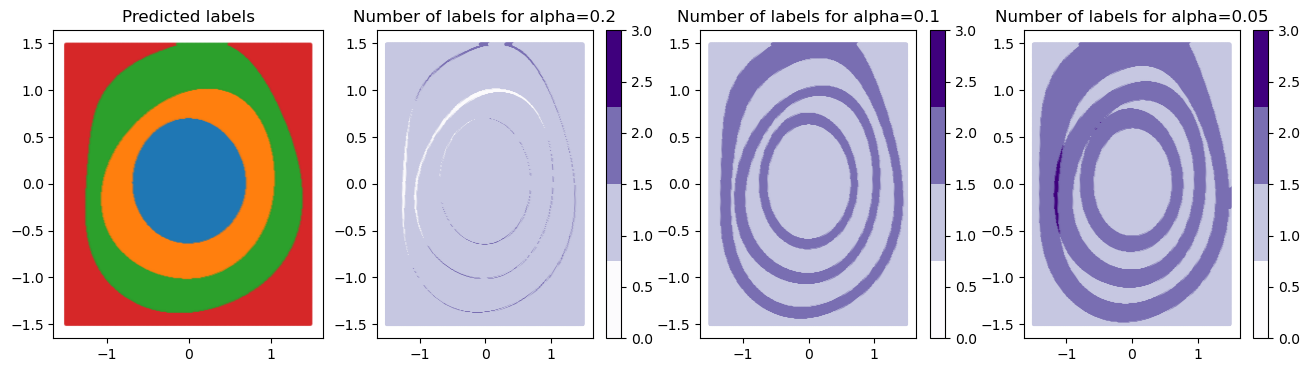

In [17]:
plot_results(alpha, X_test_mesh, y_pred_score, y_ps_score)

## APS Method

In [18]:
mapie_aps = MapieClassifier(estimator=model, cv="prefit", method="cumulated_score")
mapie_aps.fit(X_cal_masked, y_cal_masked)
y_pred_aps, y_ps_aps = mapie_aps.predict(X_test_mesh, alpha=alpha)

In [19]:
classification_ssc(y_test, mapie_aps.predict(X_test, alpha=alpha)[1])

array([[       nan, 0.95547945, 1.        , 1.        ,        nan],
       [       nan, 0.97252747, 0.99441341, 1.        ,        nan],
       [       nan, 1.        , 0.99472296, 1.        , 1.        ]])

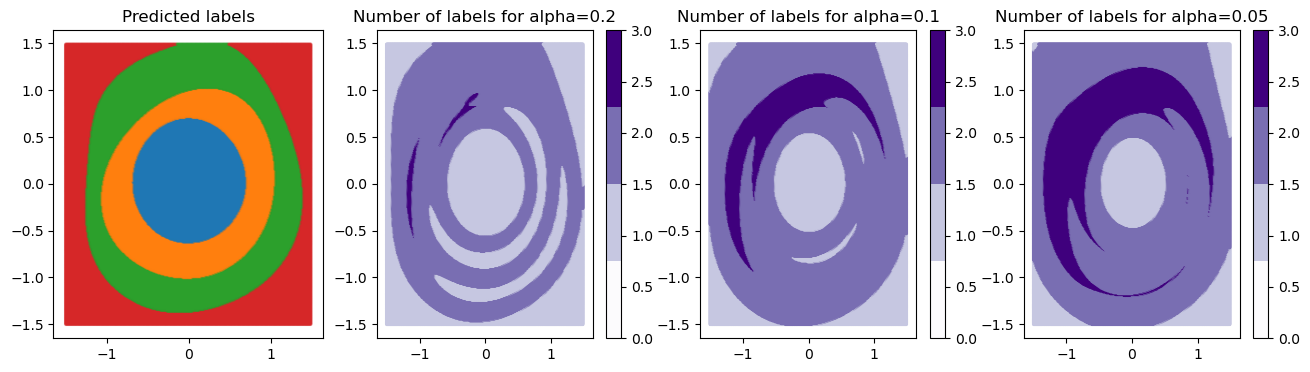

In [20]:
plot_results(alpha, X_test_mesh, y_pred_aps, y_ps_aps)

# CRF-APS with Cumulated Score residuals

In [21]:
y_res_aps = get_residual(model, X_res_masked, y_res_masked, 'crf_aps')

##### Fit residual predictor #####
regr_aps = LinearRegression().fit(X_res_masked, y_res_aps)

In [22]:
evaluate_regressor(model=model, regressor=regr_aps, X_calibration=X_cal_masked, y_calibration=y_cal_masked, method='crf_aps')

Fitted regressor MSE = 0.018936785773803765
Fitted regressor RMSE = 0.13761099437836996


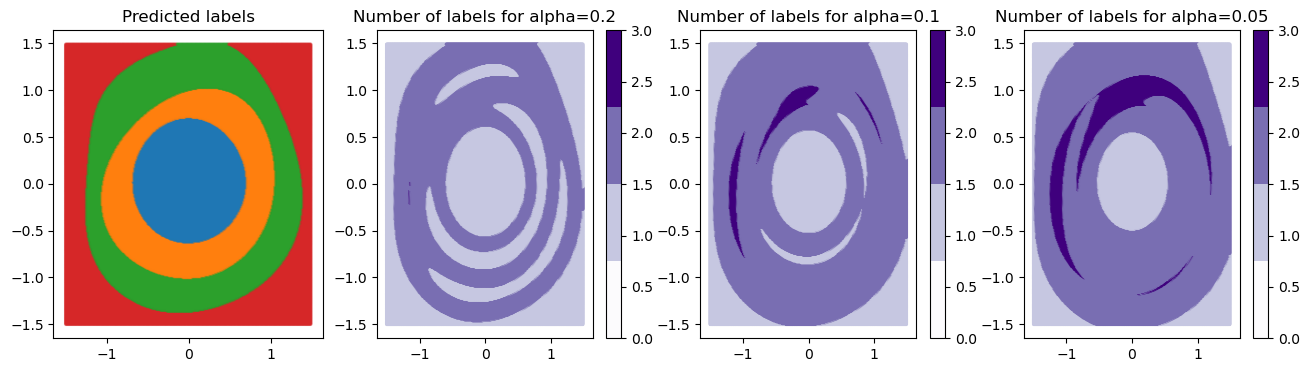

In [23]:
##### Instanciate MapieClassifier #####
mapie_crf_aps = MapieClassifier(estimator=model, cv="prefit", method="crf_aps")

##### Predict residuals and fit MapieClassifier #####
y_cal_pred_res_aps = regr_aps.predict(X_cal_masked)
mapie_crf_aps.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred_res_aps)

##### Predict test residuals and predict sets #####
y_test_mesh_pred_res_aps = regr_aps.predict(X_test_mesh)
y_pred_aps_crf, y_ps_aps_crf = mapie_crf_aps.predict(X_test_mesh, alpha=alpha, residuals=y_test_mesh_pred_res_aps)

plot_results(alpha, X_test_mesh, y_pred_aps_crf, y_ps_aps_crf)

In [24]:
##### Compute Size-Stratified Coverage metric ####
y_test_pred_res_aps = regr_aps.predict(X_test)
classification_ssc(y_test, mapie_crf_aps.predict(X_test, alpha=alpha, residuals=y_test_pred_res_aps)[1])

array([[       nan, 0.9522293 , 1.        ,        nan,        nan],
       [       nan, 0.97461929, 0.99433428, 1.        ,        nan],
       [       nan, 1.        , 0.99488491, 1.        ,        nan]])

In [25]:
print(f"Calibration residuals : min = {min(y_cal_pred_res_aps):.3f} max = {max(y_cal_pred_res_aps):.3f}")
print(f"Test residuals : min = {min(y_test_pred_res_aps):.3f} max = {max(y_test_pred_res_aps):.3f}")

Calibration residuals : min = 0.784 max = 0.895
Test residuals : min = 0.776 max = 0.891


We can see that we always have very high residuals for the Cumulated Score method

# CRF-APS with Score residuals

In [26]:
y_res_score = get_residual(model, X_res_masked, y_res_masked, 'crf_score')

##### Fit residual predictor #####
regr_score = LinearRegression().fit(X_res_masked, y_res_score)

In [27]:
evaluate_regressor(model=model, regressor=regr_score, X_calibration=X_cal_masked, y_calibration=y_cal_masked, method='crf_score')

Fitted regressor MSE = 0.06783163609586519
Fitted regressor RMSE = 0.26044507308809894


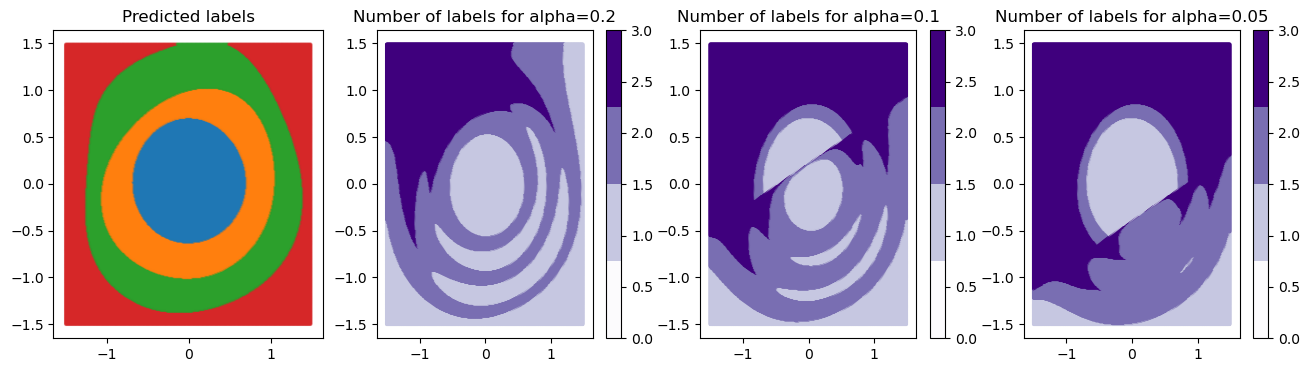

In [28]:
##### Instanciate MapieClassifier #####
mapie_crf_aps = MapieClassifier(estimator=model, cv="prefit", method="crf_aps")

##### Predict residuals and fit MapieClassifier #####
y_cal_pred_res_score = regr_score.predict(X_cal_masked)
mapie_crf_aps.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred_res_score)

##### Predict test residuals and predict sets #####
y_test_mesh_pred_res_score = regr_score.predict(X_test_mesh)
y_pred_aps_crf, y_ps_aps_crf = mapie_crf_aps.predict(X_test_mesh, alpha=alpha, residuals=y_test_mesh_pred_res_score)

plot_results(alpha, X_test_mesh, y_pred_aps_crf, y_ps_aps_crf)

In [29]:
##### Compute Size-Stratified Coverage metric ####
y_test_pred_res_score = regr_score.predict(X_test)
classification_ssc_score(y_test, mapie_crf_aps.predict(X_test, alpha=alpha, residuals=y_test_pred_res_score)[1])

array([0.93630573, 0.96601942, 0.94736842])

In [30]:
print(f"Calibration residuals : min = {min(y_cal_pred_res_score):.3f} max = {max(y_cal_pred_res_score):.3f}")
print(f"Test residuals : min = {min(y_test_pred_res_score):.3f} max = {max(y_test_pred_res_score):.3f}")

Calibration residuals : min = 0.215 max = 0.355
Test residuals : min = 0.217 max = 0.359


Here we can observe a clear indication that the residuals are noticeably minimized, tightly clustered within a narrow interval.

# CRF-SCORE

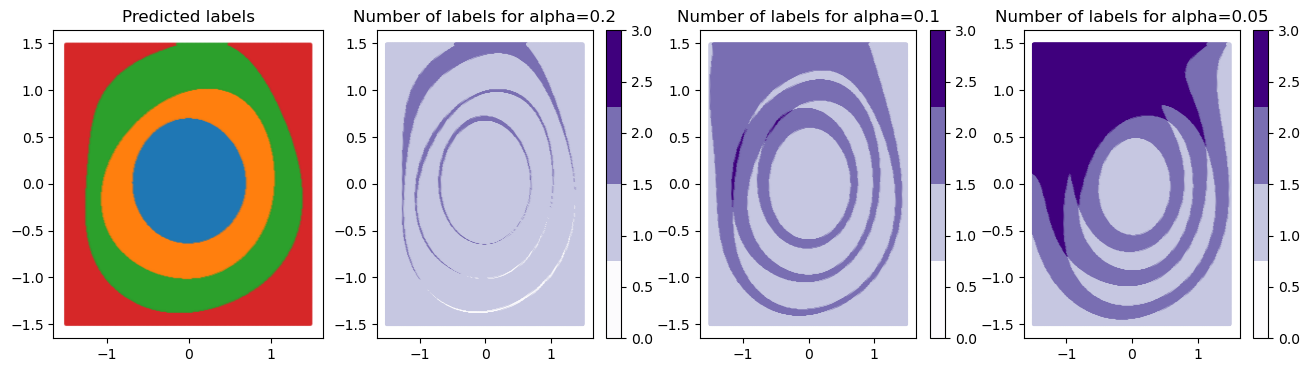

In [31]:
##### Instanciate MapieClassifier #####
mapie_crf_score = MapieClassifier(estimator=model, cv="prefit", method="crf_score")

##### Predict residuals and fit MapieClassifier #####
y_cal_pred_score = regr_score.predict(X_cal_masked)
mapie_crf_score.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred_score)

##### Predict test residuals and predict sets #####
y_test_mesh_pred_res_score = regr_score.predict(X_test_mesh)
y_pred_crf_score, y_ps_crf_score = mapie_crf_score.predict(X_test_mesh, alpha=alpha, residuals=y_test_mesh_pred_res_score)

plot_results(alpha, X_test_mesh, y_pred_crf_score, y_ps_crf_score)

In [32]:
##### Compute Size-Stratified Coverage metric ####
classification_ssc_score(y_test, mapie_crf_score.predict(X_test, alpha=alpha, residuals=y_test_pred_res_score)[1])

array([0.        , 0.9057971 , 0.93770492])

# SSAPS

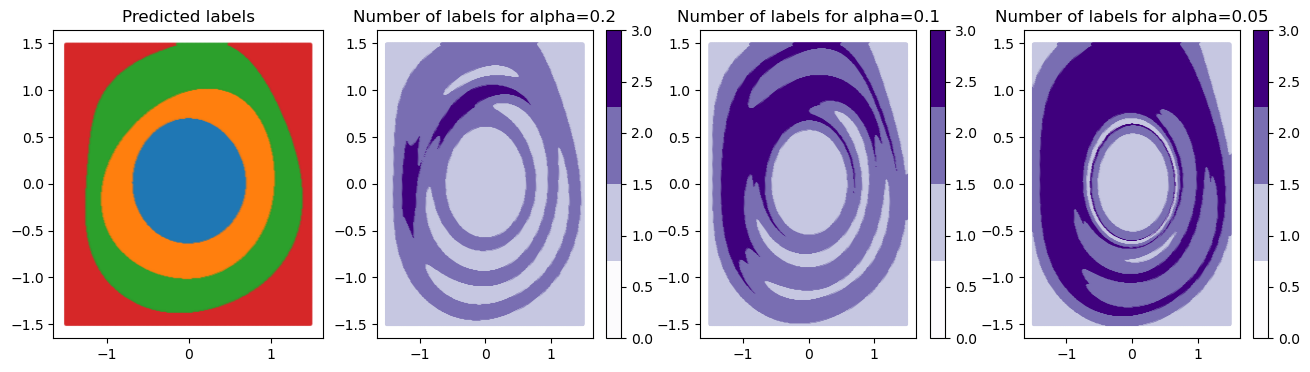

In [33]:
##### Instanciate MapieClassifier #####
mapie_ssaps = MapieClassifier(estimator=model, cv="prefit", method="ssaps")

##### Predict residuals and fit MapieClassifier #####
y_cal_pred_score = regr_score.predict(X_cal_masked)
mapie_ssaps.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred_score)

##### Predict test residuals and predict sets #####
y_test_mesh_pred_res_score = regr_score.predict(X_test_mesh)
y_pred_crf_score, y_ps_crf_score = mapie_ssaps.predict(X_test_mesh, alpha=alpha, residuals=y_test_mesh_pred_res_score)

plot_results(alpha, X_test_mesh, y_pred_crf_score, y_ps_crf_score)

In [34]:
##### Compute Size-Stratified Coverage metric ####
classification_ssc_score(y_test, mapie_ssaps.predict(X_test, alpha=alpha, residuals=y_test_pred_res_score)[1])

array([0.94152047, 0.95849057, 0.94857143])

# Calibration of the methods

From now on, we will no longer use the residuals obtained with the Cumulated Score method, but only those obtained with the Score method (softmax of the true label).

In [35]:
method_params = {
    "score": "score",
    "aps": "cumulated_score",
    "crf_score": "crf_score",
    "crf_aps": "crf_aps",
    "raps": "raps",
    "ssaps": "ssaps",
}

In [36]:
y_preds, y_pss = {}, {}
alphas = np.arange(0.01, 1, 0.01)

for name, method in method_params.items():
    if name in ["crf_score", "crf_aps", "ssaps"]:
        mapie = MapieClassifier(estimator=model, cv="prefit", method=method)

        y_cal_pred = regr_score.predict(X_cal_masked)
        mapie.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred)
        
        y_test_pred_res = regr_score.predict(X_test)
        y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas, residuals=y_test_pred_res)
    else:
        mapie = MapieClassifier(estimator=model, method=method, cv="prefit", random_state=42) 
        mapie.fit(X_cal_masked, y_cal_masked)
        y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas)

In [37]:
nulls, coverages, accuracies, sizes = {}, {}, {}, {}
for name, method in method_params.items():
    accuracies[name] = accuracy_score(y_test, y_preds[name])
    nulls[name] = [
        count_null_set(y_pss[name][:, :, i])  for i, _ in enumerate(alphas)
    ]
    coverages[name] = [
        classification_coverage_score(
            y_test, y_pss[name][:, :, i]
        ) for i, _ in enumerate(alphas)
    ]
    sizes[name] = [
        y_pss[name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
    ]

In [38]:
coverage_90 = {method: coverage[9] for method, coverage in coverages.items()}
null_90 = {method: null[9] for method, null in nulls.items()}
width_90 = {method: width[9] for method, width in sizes.items()}
y_ps_90 = {method: y_ps[:, :, 9] for method, y_ps in y_pss.items()}

In [39]:
summary_df = pd.concat(
    [
        pd.Series(coverage_90),
        pd.Series(null_90),
        pd.Series(width_90)
    ],
    axis=1,
    keys=["Coverages", "Number of null sets", "Average prediction set sizes"]
).round(3)

In [40]:
summary_df

,Coverages,Number of null sets,Average prediction set sizes
score,0.944,0,1.259
aps,0.986,0,1.641
crf_score,0.929,0,1.252
crf_aps,0.986,0,1.833
raps,0.987,0,1.707
ssaps,0.976,0,1.529


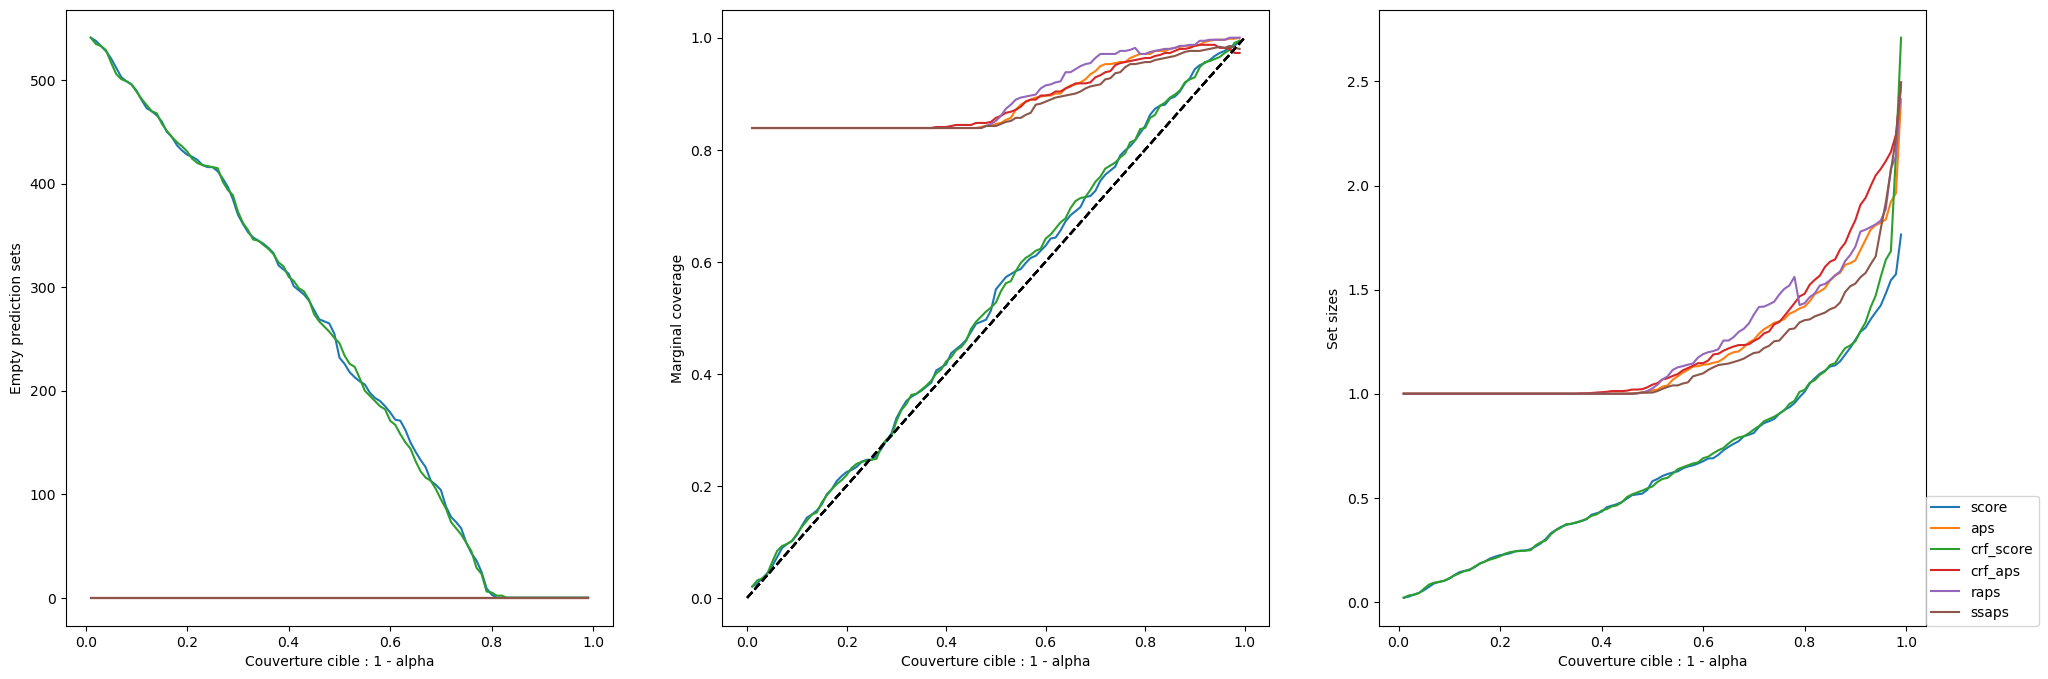

In [41]:
vars_y = [nulls, coverages, sizes]
labels_y = ["Empty prediction sets", "Marginal coverage", "Set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
for i, var in enumerate(vars_y):
    for name, method in method_params.items():
        axs[i].plot(1 - alphas, var[name], label=name)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Couverture cible : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=10, loc=[1, 0])

# Analyze results 

In [42]:
# APS residuals
y_res_aps = get_residual(model, X_res_masked, y_res_masked, 'crf_aps')
regr_aps = LinearRegression().fit(X_res_masked, y_res_aps)
test_residuals_aps = get_residual(model, X1_filtered, y1_filtered, 'crf_aps')
test_preds_res_aps = regr_aps.predict(X1_filtered)

# Score residuals
y_res_score = get_residual(model, X_res_masked, y_res_masked, 'crf_score')
regr_score = LinearRegression().fit(X_res_masked, y_res_score)
test_residuals_score = get_residual(model, X1_filtered, y1_filtered, 'crf_score')
test_preds_res_score = regr_score.predict(X1_filtered)

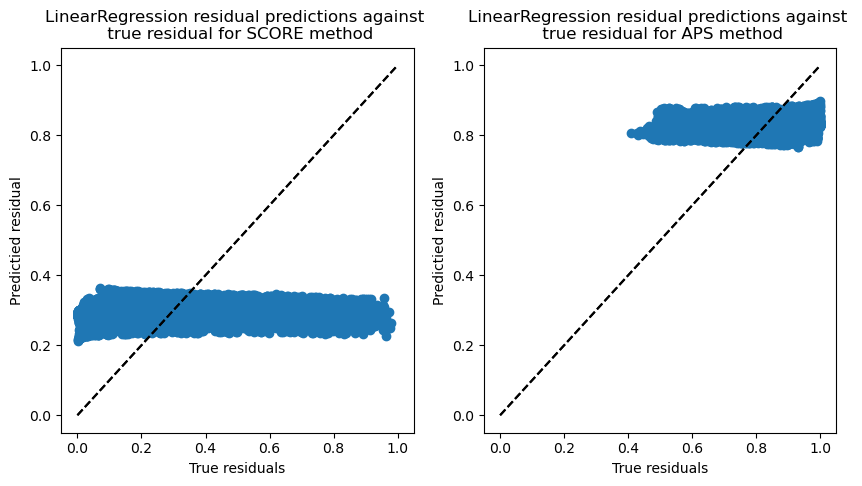

In [43]:
ncols = 2
nrows = 1
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))

for c in range(ncols):
    ax[c].plot([[0, 0], [1, 1]], linestyle='dashed', c="black")
    ax[c].set_xlabel("True residuals")
    ax[c].set_ylabel("Predictied residual")

ax[0].scatter(test_residuals_score, test_preds_res_score)
ax[1].scatter(test_residuals_aps, test_preds_res_aps)

ax[0].set_title("LinearRegression residual predictions against \n true residual for SCORE method")
ax[1].set_title("LinearRegression residual predictions against \n true residual for APS method")
plt.show()

We can observe that the predicted residuals on the test set are either high or low and doesn't match at all with the true residuals.
We can conclude that our residuals estimator doesn't learn anything.

# Visualize residuals by zone

Let's explore the reason behind the apparent validity of our plots, particularly when using higher prediction sets in regions where we introduced uncertainty by masking samples with insignificant residuals.

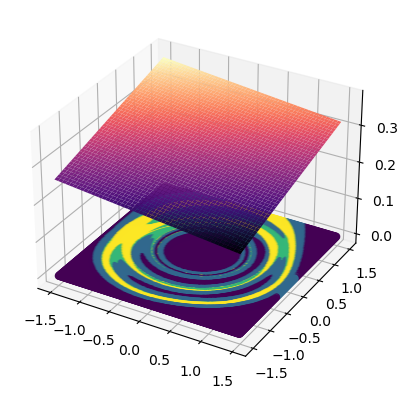

In [81]:
from matplotlib import cm

Z_surface_preds = regr_score.predict(X_test_mesh).reshape(xx.shape)
# y_test_mesh_true_res_score = get_residual(model, X_test_mesh, y_test_mesh, "crf_score").reshape(xx.shape)

# Plot the surface
y_pi_sums = y_ps_crf_score[:, :, 2].sum(axis=1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xx, yy, Z_surface_preds, vmin=Z_surface_preds.min(), cmap=cm.magma)
# ax.plot_surface(xx, yy, y_test_mesh_true_res_score, vmin=Z_surface_preds.min(), cmap='coolwarm')
ax.scatter(xx, yy, c=y_pi_sums)

ax.set_xlabel='X'
ax.set_ylabel='Y'
plt.show()

The observed linear regression slope for the residuals estimator appears to be in the correct direction, but the coefficient is notably inadequate. This discrepancy might clarify why the results seem consistent superficially, but, in reality, they are not satisfactory.

# Neural Network residuals estimator

In [82]:
from sklearn.neural_network import MLPRegressor

regr_nn = MLPRegressor(
    hidden_layer_sizes=400, 
    activation='relu',
    solver='adam',
    max_iter=500,
).fit(X=X_res_masked, y=y_res_score)

In [83]:
evaluate_regressor(model=model, regressor=regr_nn, X_calibration=X_cal_masked, y_calibration=y_cal_masked, method='crf_score')

Fitted regressor MSE = 0.05933038102720098
Fitted regressor RMSE = 0.2435782852127853


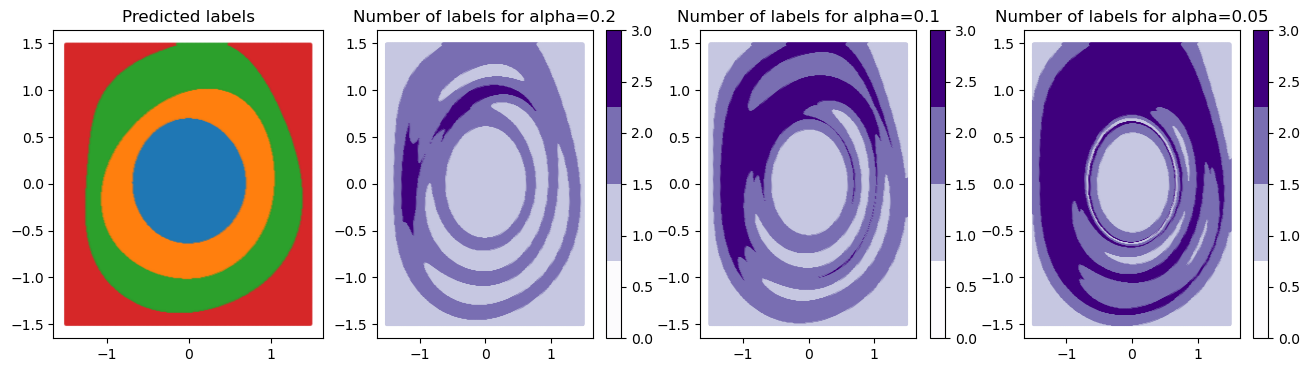

In [84]:
##### Instanciate MapieClassifier #####
mapie_ssaps = MapieClassifier(estimator=model, cv="prefit", method="ssaps")

##### Predict residuals and fit MapieClassifier #####
y_cal_pred_score = regr_nn.predict(X_cal_masked)
mapie_ssaps.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred_score)

##### Predict test residuals and predict sets #####
y_test_mesh_pred_res_score = regr_nn.predict(X_test_mesh)
y_pred_crf_score, y_ps_crf_score = mapie_ssaps.predict(X_test_mesh, alpha=alpha, residuals=y_test_mesh_pred_res_score)

plot_results(alpha, X_test_mesh, y_pred_crf_score, y_ps_crf_score)

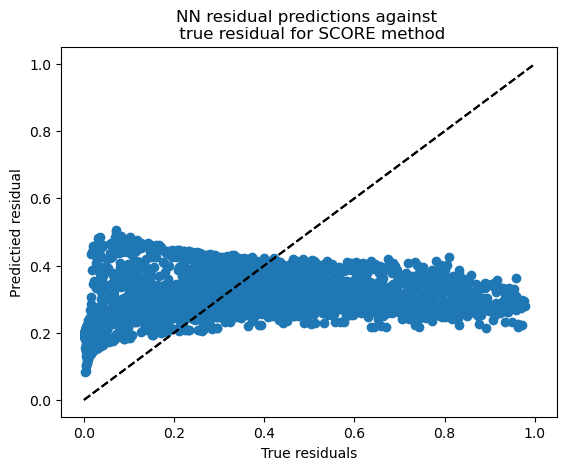

In [85]:
# Score residuals
test_residuals_score = get_residual(model, X1_filtered, y1_filtered, 'crf_score')
test_preds_res_score = regr_nn.predict(X1_filtered)

plt.plot([[0, 0], [1, 1]], linestyle='dashed', c="black")
plt.xlabel("True residuals")
plt.ylabel("Predictied residual")

plt.scatter(test_residuals_score, test_preds_res_score)
plt.title("NN residual predictions against \n true residual for SCORE method")
plt.show()

# Results if we manage to get the perfect residuals estimator

We can't compute metrics for methods Score and CRF-Score because we use the true residuals from Score method

In [86]:
method_params = {
    "aps": "cumulated_score",
    "crf_aps": "crf_aps",
    "raps": "raps",
    "ssaps": "ssaps",
}

In [87]:
y_preds, y_pss = {}, {}
alphas = np.arange(0.01, 1, 0.01)

for name, method in method_params.items():
    if name in ["crf_aps", "ssaps"]:
        mapie = MapieClassifier(estimator=model, cv="prefit", method=method)

        y_cal_res_true = get_residual(model, X_cal_masked, y_cal_masked, "crf_score")
        mapie.fit(X_cal_masked, y_cal_masked, residuals=y_cal_res_true)
        
        y_test_res_true = get_residual(model, X_test, y_test, "crf_score")
        y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas, residuals=y_test_res_true)
    else:
        mapie = MapieClassifier(estimator=model, method=method, cv="prefit", random_state=42) 
        mapie.fit(X_cal_masked, y_cal_masked)
        y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas)

In [88]:
nulls, coverages, accuracies, sizes = {}, {}, {}, {}
for name, method in method_params.items():
    accuracies[name] = accuracy_score(y_test, y_preds[name])
    nulls[name] = [
        count_null_set(y_pss[name][:, :, i])  for i, _ in enumerate(alphas)
    ]
    coverages[name] = [
        classification_coverage_score(
            y_test, y_pss[name][:, :, i]
        ) for i, _ in enumerate(alphas)
    ]
    sizes[name] = [
        y_pss[name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
    ]

In [89]:
coverage_90 = {method: coverage[9] for method, coverage in coverages.items()}
null_90 = {method: null[9] for method, null in nulls.items()}
width_90 = {method: width[9] for method, width in sizes.items()}
y_ps_90 = {method: y_ps[:, :, 9] for method, y_ps in y_pss.items()}

In [90]:
summary_df = pd.concat(
    [
        pd.Series(coverage_90),
        pd.Series(null_90),
        pd.Series(width_90)
    ],
    axis=1,
    keys=["Coverages", "Number of null sets", "Average prediction set sizes"]
).round(3)

In [91]:
summary_df

,Coverages,Number of null sets,Average prediction set sizes
aps,0.986,0,1.641
crf_aps,0.973,0,2.694
raps,0.987,0,1.707
ssaps,0.958,0,1.701


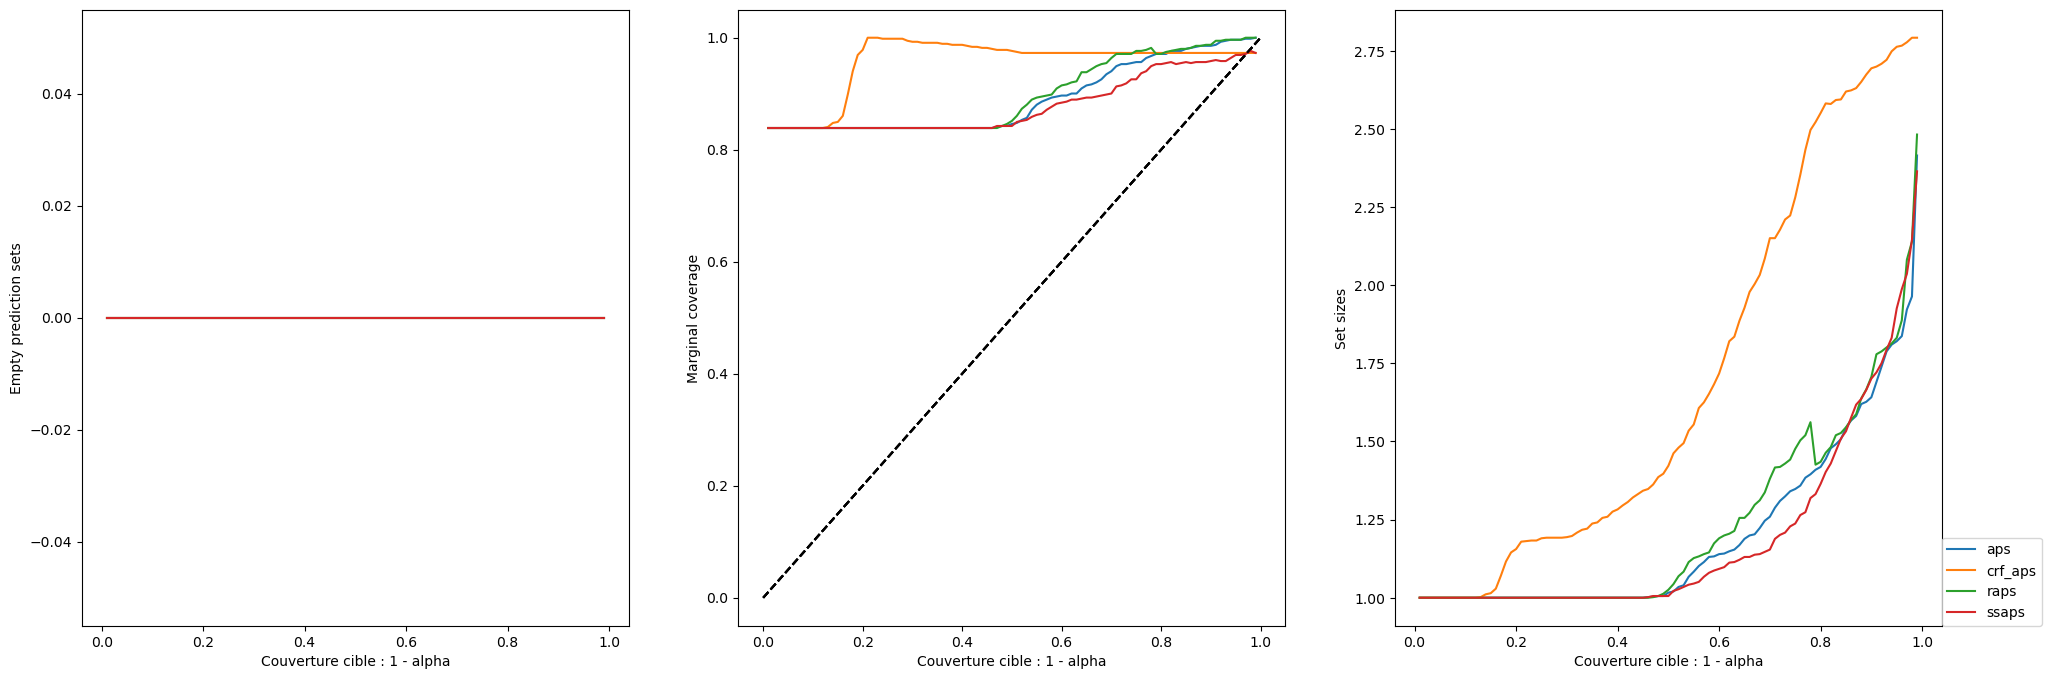

In [92]:
vars_y = [nulls, coverages, sizes]
labels_y = ["Empty prediction sets", "Marginal coverage", "Set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
for i, var in enumerate(vars_y):
    for name, method in method_params.items():
        axs[i].plot(1 - alphas, var[name], label=name)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Couverture cible : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=10, loc=[1, 0])

# Visualize SSAPS with true residuals

We create a smaller meshgrid to avoid making predictions for values on the border of the plot, as it could lead to incorrect residuals and consequently, inaccurate prediction set sizes.

In [117]:
x_min, x_max, y_min, y_max, step = -1, 1, -1, 1, 0.01
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)

We train a KNN model on the complete dataset without any points masked, achieving a high accuracy of 0.99. The objective is to use this model to predict the y class for each point in the meshgrid.

In [118]:
knn_cls = SVC().fit(X2_filtered, y2_filtered)
y_test_mesh = pd.Series(knn_cls.predict(X_test_mesh))

Now, we utilize the actual classes of each point in the meshgrid to calculate the true residuals. This allows us to visualize the potential outcomes of the SSAPS method if we had a nearly perfect residuals estimator.

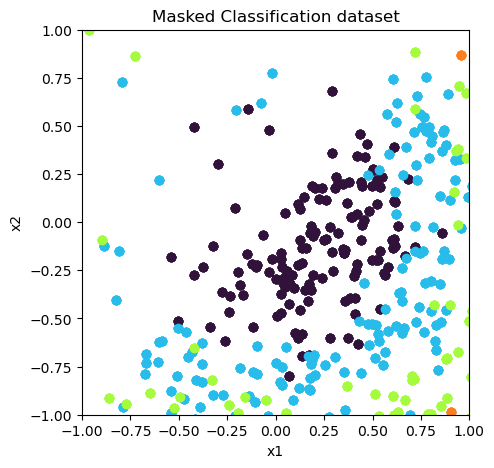

In [119]:
unique_classes = np.unique(y1)
plt.figure(figsize=(5, 5))
colors = plt.cm.turbo(np.linspace(0, 1, len(unique_classes)))
for i, cls in enumerate(unique_classes):
    class_indices = y1 == cls
    for i, cls in enumerate(unique_classes):
        class_indices = y_train_masked == cls
        plt.scatter(
            X_train_masked.loc[class_indices, "x"],
            X_train_masked.loc[class_indices, "y"],
            color=colors[i],
            label="Class {}".format(cls),
        )
    plt.xlabel("x1")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.ylabel("x2")
    plt.title("Masked Classification dataset")

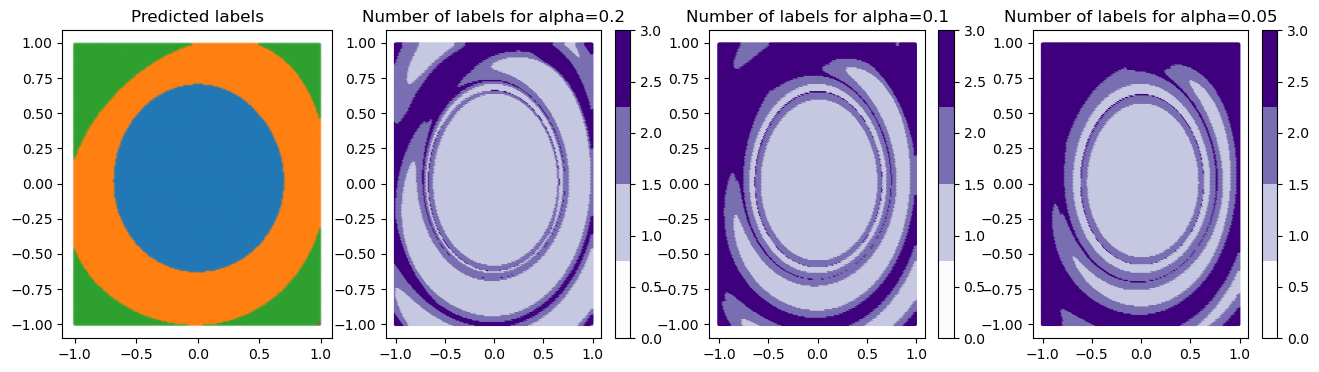

In [120]:
##### Instanciate MapieClassifier #####
mapie_ssaps = MapieClassifier(estimator=model, cv="prefit", method="ssaps")

##### Predict residuals and fit MapieClassifier #####
y_cal_pred_score = get_residual(model, X_cal_masked, y_cal_masked, "crf_score")
mapie_ssaps.fit(X_cal_masked, y_cal_masked, residuals=y_cal_pred_score)

##### Predict test residuals and predict sets #####
y_test_mesh_pred_res_score = get_residual(model, X_test_mesh, y_test_mesh, "crf_score")
y_pred_crf_score, y_ps_crf_score = mapie_ssaps.predict(X_test_mesh, alpha=alpha, residuals=y_test_mesh_pred_res_score)

plot_results(alpha, X_test_mesh, y_pred_crf_score, y_ps_crf_score)